## Imports

In [12]:
from sklearn import preprocessing, decomposition, cluster
from matplotlib import pyplot as plt
from collections import namedtuple
import pandas as pd
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

# Load Dataset
Load the Million Song Dataset from 'YearPredictionsMSP.txt' (expected to be in the data folder)  
Dataset Source: https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD  

The following information is from the UCI webpage for this dataset (linked above):

## Data Set Information:
You should respect the following train / test split:  
train: first 463,715 examples  
test: last 51,630 examples  
It avoids the 'producer effect' by making sure no song  
from a given artist ends up in both the train and test set.  

## Attribute Information:  
90 attributes, 12 = timbre average, 78 = timbre covariance  
The first value is the year (target), ranging from 1922 to 2011.  
Features extracted from the 'timbre' features from The Echo Nest API.  
We take the average and covariance over all 'segments', each segment  
being described by a 12-dimensional timbre vector.  

## Relevant Papers:
see the website: http://millionsongdataset.com/

In [13]:
# Load the data from the text file
raw_df = pd.read_csv("/Users/bootsonthemoon/Desktop/YearPredictionMSD.txt", header=None)
years = raw_df[0].to_numpy(dtype=int)

# Drop the year column and assign the attribute data to a numpy ndarray
raw_df.drop(0, axis=1, inplace=True)
attribute_data = raw_df.to_numpy()

In [4]:
# Split the raw data into training and test sets
DataContainer = namedtuple("DataContainer", ["years", "data"])
TRAIN_IDX = np.arange(0, 463715, dtype=int)
TEST_IDX = np.arange(463715, 463715 + 51630, dtype=int)

# Split data into training and test set, and also separate the year labels
# from the attributes
train = DataContainer(years[TRAIN_IDX], attribute_data[TRAIN_IDX])
test = DataContainer(years[TEST_IDX], attribute_data[TEST_IDX])

# Print the shape of the training and test data to ensure it
# was loaded correctly. Expect 463715/51630 rows, and 90 columns
print(f"Train Data Shape: {train.data.shape}")
print(f"Test Data Shape:  {test.data.shape}")

Train Data Shape: (463715, 90)
Test Data Shape:  (51630, 90)


## Normalization

In [5]:
# Normalize the training and test data
preprocessing.normalize(train.data, norm='l2', axis=1, copy=False)
preprocessing.normalize(test.data, norm='l2', axis=1, copy=False)

array([[ 0.01607807, -0.01087973,  0.01124632, ..., -0.00136662,
         0.01288736,  0.00253795],
       [ 0.03313346, -0.00181721,  0.02764532, ..., -0.00252199,
        -0.04337574, -0.00328028],
       [ 0.01554794,  0.00408662,  0.00374916, ..., -0.00371351,
         0.00909358, -0.00196716],
       ...,
       [ 0.00744298,  0.0020876 , -0.00638606, ..., -0.0010014 ,
         0.00890007, -0.00133487],
       [ 0.01035857,  0.00759515, -0.00078563, ...,  0.00476634,
         0.00347843,  0.00932261],
       [ 0.02740005,  0.03123568,  0.01394611, ..., -0.00291405,
         0.01709609,  0.00643218]])

## Dimensionality Reduction Using Truncated SVD

In [6]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=30, n_iter=7, random_state=42)
denseMatrixTrunc = svd.fit_transform(train.data)

### Cluster after SVD Truncation

In [7]:
kmeans = cluster.KMeans(n_clusters=12)
kmeans.fit(denseMatrixTrunc)

KMeans(n_clusters=12)

### Visualize Truncated SVD Cluster

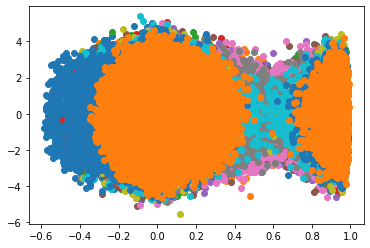

In [8]:
plt.figure()
for i in set(kmeans.labels_):
    x = denseMatrixTrunc[kmeans.labels_ == i]
    y = np.random.randn(x.size)
    plt.scatter(x, y)

### Create Elbow graph to see where optimal clustering is

In [40]:
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 15)
 
for k in K:
    
    kmeans = KMeans(n_clusters=k).fit(denseMatrixTrunc)
    kmeans.fit(denseMatrixTrunc)
 
    distortions.append(sum(np.min(cdist(denseMatrixTrunc, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / denseMatrixTrunc.shape[0])
    inertias.append(kmeans.inertia_)
 
    mapping1[k] = sum(np.min(cdist(denseMatrixTrunc, kmeans.cluster_centers_,
                                   'euclidean'), axis=1)) / denseMatrixTrunc.shape[0]
    mapping2[k] = kmeans.inertia_

In [43]:
for key, val in mapping2.items():
    print(f'{key} : {val}')

1 : 79562.93586628366
2 : 66523.34026495775
3 : 60034.88817068338
4 : 56767.5161481158
5 : 54533.94440479237
6 : 52788.73266756338
7 : 51304.58465924179
8 : 50058.87841505998
9 : 49099.40328260362
10 : 48261.309117900826
11 : 47537.172186137956
12 : 46875.90189346995
13 : 46280.74659713029
14 : 45712.097260417584


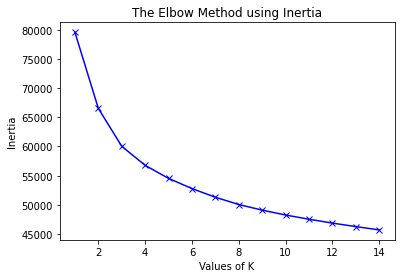

In [44]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

## Dimensionality Reduction Using PCA

In [25]:
pca = decomposition.PCA(n_components=25)
pca.fit(train.data)
train_pca = DataContainer(train.years, pca.transform(train.data))
print(f"Training Data PCA Total Explained Variance Ratio = {pca.explained_variance_ratio_.sum()}")

pca = decomposition.PCA(n_components=25)
pca.fit(train.data)
test_pca = DataContainer(test.years, pca.transform(test.data))
print(f"Test Data PCA Total Explained Variance Ratio = {pca.explained_variance_ratio_.sum()}")

Training Data PCA Total Explained Variance Ratio = 0.9049648778857733
Test Data PCA Total Explained Variance Ratio = 0.9049637831450842


# Clustering

In [17]:
kmeans = cluster.KMeans(n_clusters=8)
kmeans.fit(train.data)

KMeans()

# Results Visualization

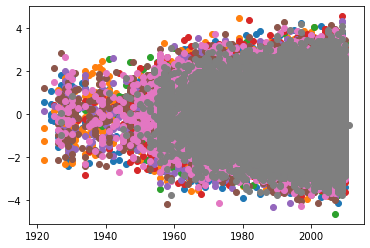

In [27]:
plt.figure()
for i in set(kmeans.labels_):
    x = train.years[kmeans.labels_ == i]
    y = np.random.randn(x.size)
    plt.scatter(x, y)

## DB Scan Example using TruncatedSVD

Text(0, 0.5, 'Timbre')

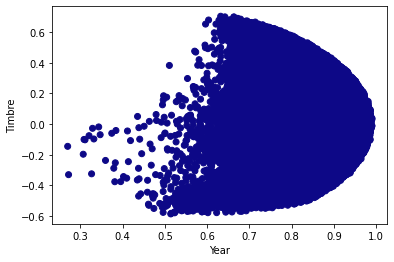

In [16]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(denseMatrixTrunc)
# cluster the data into five clusters
dbscan = DBSCAN(eps=0.123, min_samples = 2)
clusters = dbscan.fit_predict(X_scaled)
# plot the cluster assignments
plt.scatter(denseMatrixTrunc[:, 0], denseMatrixTrunc[:, 1], c=clusters, cmap="plasma")
plt.xlabel("Year")
plt.ylabel("Timbre")

In [131]:
# Load the data from the text file
raw_df_sample = pd.read_csv("/Users/bootsonthemoon/Desktop/YearPredictionMSD.txt", header=None)
random_sample = raw_df_sample.sample(n=1)

years = random_sample[0].to_numpy(dtype=int)

# Drop the year column and assign the attribute data to a numpy ndarray
random_sample.drop(0, axis=1, inplace=True)
sample_attribute_data = random_sample.to_numpy()

print(sample_attribute_data)

[[ 4.7705090e+01  4.8423680e+01  6.2507380e+01  6.6661500e+00
  -2.6571190e+01 -1.6373840e+01  6.3050000e-02  4.6948000e+00
   1.3613700e+01  4.6001200e+00  1.5122000e+00  1.1471390e+01
   1.0451790e+01  5.6884181e+02  6.3268687e+02  3.3985508e+02
   3.9173115e+02  2.9374670e+02  3.1190940e+02  1.6417350e+02
   2.5146824e+02  9.5541390e+01  1.1829765e+02  1.8317893e+02
  -5.0788900e+00  1.1947221e+02  3.9090630e+01 -1.0114010e+01
   3.4573220e+01  2.1307600e+00  5.4418640e+01 -3.3309850e+01
   3.5097120e+01 -7.6610900e+00  1.7381870e+01  1.2891300e+01
   4.7534600e+00 -7.1007920e+01 -6.9900260e+01 -3.3369870e+01
   1.1601700e+01 -3.1326610e+01 -1.7382560e+01  1.7530310e+01
   3.7575700e+00  2.7926400e+00 -1.2070180e+01  6.8898950e+01
  -2.5882180e+01 -1.0717220e+01 -4.8669210e+01  1.6840470e+01
   1.4532680e+01  7.1611200e+00 -1.9790250e+01 -2.0662620e+01
   1.1866003e+02 -1.9287330e+01 -2.2382170e+01  2.5879950e+01
   2.9160000e-01  2.3515100e+01 -3.0496600e+00  1.0232690e+02
  -2.314

In [132]:
random_sample = raw_df_sample.sample(n=1)

# Drop the year column and assign the attribute data to a numpy ndarray
random_sample.drop(0, axis=1, inplace=True)
sample_attribute_data = random_sample.to_numpy()

In [133]:
cluster_order = []
difference_matrix = []
SSE_diffs = []

for i in range(0, len(kmeans.cluster_centers_)):
    difference = kmeans.cluster_centers_[i] - sample_attribute_data
    difference_matrix.append(difference)

print(difference_matrix)

[array([[-3.72133481e+01,  8.69696229e+01, -2.79323801e+00,
         1.57466187e+01, -9.55081420e+00,  5.45335109e+00,
         8.95971588e+00,  4.81722449e-01,  3.60486478e+00,
         1.49007353e+00,  2.12681492e+00, -9.95558555e+00,
        -3.63007429e+01, -1.69251170e+03, -2.57161984e+03,
        -1.83060683e+03, -1.13325280e+03, -8.56010155e+02,
        -6.67729941e+02, -4.07386369e+02, -7.48696812e+02,
        -2.58728811e+02, -2.65833539e+02, -3.18079276e+02,
        -1.08649127e+02, -4.20310215e+02, -3.52629927e+02,
        -3.91335324e+01,  2.10280155e+02,  3.47662310e+01,
         1.58059654e+01, -1.57311440e+01, -1.53730822e+02,
         5.12669506e+00,  6.69941058e+00, -2.10938334e+02,
        -8.57179743e+01, -2.90567842e+02,  2.52547671e+02,
         1.49893280e+01, -2.25060692e+01, -7.18205208e+01,
         4.55589621e+01,  4.97693165e+01,  2.89310019e+01,
        -5.42773507e+01, -3.40891923e+02, -1.77191994e+02,
         8.86970346e+01,  7.48767120e+01,  1.12824581e+

In [134]:
order_matrix = []

for i in range(0, len(difference_matrix)):
    order = abs(np.mean(difference_matrix[i]))
    order_matrix.append(order)
    order_matrix.append
print(order_matrix)

[148.47944895577757, 148.47861068048022, 148.48058334950102, 148.480165587803, 148.48457764586178, 148.48228946377574, 148.4782950870185, 148.4780534084972]


In [137]:
#smallest delta represents sample data closest to the centroid
index_min = np.argmin(order_matrix)
print(index_min)

7
